# **Problem Statement**
This project builds a Retrieval-Augmented Generation (RAG) system for answering questions from insurance policy documents using LangChain, GROQ AI, and Chroma. It provides accurate and concise answers by combining document retrieval with generative language models.

### RAG - System Architecture

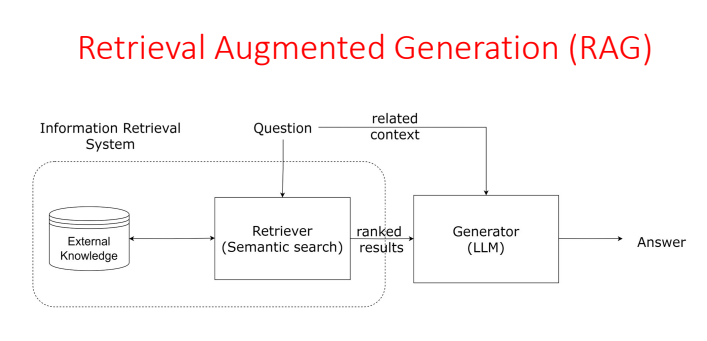

# **Introduction**
## Retrieval-Augmented Generation (RAG) System using LangChain

This notebook demonstrates the implementation of a **Retrieval-Augmented Generation (RAG)** system using **LangChain**. The system is designed to perform document retrieval and generate informative responses based on policy documents. Unlike traditional systems that rely on OpenAI APIs, we use **GROQ AI**, an open-source tool, to handle the generative model component.

### Tools and Libraries Used:
- **LangChain**: Framework for building language model pipelines.
- **GROQ AI**: Open-source alternative to OpenAI for generative AI tasks.
- **SBERT**: Embedding model for transforming text into vector representations.
- **Chroma**: A vector database for storing and querying text embeddings.
- **Text Splitters**: To preprocess large documents into manageable chunks for efficient retrieval.

## **Solution POC**
A typical RAG application has two main components:

- **Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

- **Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

The most common full sequence from raw data to answer looks like:

### Indexing
- **Load**: First we need to load our data.
- **Split**: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model.
- **Store**: We need somewhere to store and index our splits, so that they can be searched over later.

<img src="https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png" alt="RAG Indexing" width="700">

### Retrieval and generation
- **Retrieve**: Given a user input, relevant splits are retrieved from storage using a Retriever.
- **Generate**: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data.

<img src="https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png" alt="RAG Retrieval and generation" width="700">

### Step 1: Install the necessary libraries

In [1]:
!pip install --quiet --upgrade langchain langchain-community langchain-chroma langchain-groq pypdf sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.6 MB/s eta 0:0

### Step 2: Mount Google Drive and Set the API key

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import os

# Set the LangChain API key from a file
filepath = "/content/drive/MyDrive/HelpMate-Project/"
with open(filepath + "LANGCHAIN_API_Key.txt", "r") as f:
    os.environ["LANGCHAIN_API_KEY"] = ' '.join(f.readlines()).strip()

# Enable LangChain tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"

### LangChain with GROQ AI vs. OpenAI
In this project, **LangChain** is used with **GROQ AI** (an open-source, free alternative) instead of **OpenAI**. **GROQ AI** provides a cost-free, high-performance solution, while LangChain offers flexibility to integrate multiple LLMs for document retrieval and generation, making it a more adaptable choice than **LlamaIndex**.

In [4]:
import os

# Define the file path for the API key
filepath = "/content/drive/MyDrive/HelpMate-Project/"
with open(filepath + "GROQ_API_Key.txt", "r") as f:
    os.environ["GROQ_API_KEY"] = f.read().strip()

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-70b-8192")

### Step 3: Data Ingestion and Preprocessing
In this step, we load the policy documents from a specified source (PDF files) and preprocess them for embedding generation. This involves removing unnecessary characters, tokenizing the text, and converting the content into a format suitable for embedding models. The goal is to prepare the document data for efficient retrieval during the question-answering process.

#### Key Operations:
- **Loading the Document Data**: We load the insurance policy documents from a specified folder using the `DirectoryLoader`.
- **Preprocessing**: The documents are split into manageable chunks using the `RecursiveCharacterTextSplitter` to ensure that the data is in a format suitable for embeddings.


Dataset:

- For this HelpMate AI project, the insurance documents can be downloaded from the following [link](https://cdn.upgrad.com/uploads/production/8e278245-506c-4c8c-9246-892280692919/Policy+Documents.zip)

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

file_path = "/content/drive/MyDrive/Policy-Documents"
loader = DirectoryLoader(file_path, glob="**/*.pdf", loader_cls=PyPDFLoader)
# Use DirectoryLoader to load all PDF files in the directory

docs = loader.load()

print(f"Loaded {len(docs)} documents")

Loaded 217 documents


In [7]:
docs[0]

Document(metadata={'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'page': 0}, page_content='HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond \nA non-participating, non-linked savings insurance plan \n \n \n Page 1 of 27 \n \nPart A \n<<01 January 2021>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>> \n \nDear <<Policyholder’s Name>>,  \n \nSub: Your Policy no. <<>> \nWe are glad to inform you that your proposal has been accepted and the HDFC Life Sanchay Plus Policy \n(“Policy”) being this Policy, has been issued. We have made every effort to design your Policy in a simple format. \nWe have highlighted items of importance so that you may recognise them easily. \nPolicy document: \nAs an evidence of the insurance contract between HDFC Life Insurance Company Limited and you, the Policy is \nenclosed herewith. Please preserve this documen

In [8]:
print(docs[0].page_content[0:500])
print(docs[0].metadata)

HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond 
A non-participating, non-linked savings insurance plan 
 
 
 Page 1 of 27 
 
Part A 
<<01 January 2021>> 
<<Policyholder’s Name>>  
<<Policyholder’s Address>> 
<<Policyholder’s Contact Number>> 
 
Dear <<Policyholder’s Name>>,  
 
Sub: Your Policy no. <<>> 
We are glad to inform you that your proposal has been accepted and the HDFC Life Sanchay Plus Policy 
(“Policy”) being this Policy, has been issued. We have made every 
{'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'page': 0}


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

760

In [10]:
len(all_splits[0].page_content)

991

In [11]:
all_splits[10].metadata

{'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf',
 'page': 3,
 'start_index': 709}

### Step 4: Embedding Generation

In this step, we convert the preprocessed document text into dense vector embeddings using **SBERT** (Sentence-BERT). These embeddings capture the semantic meaning of the text, enabling us to perform similarity-based retrieval. Documents that are semantically similar will have embeddings that are close to each other in the vector space. Once the embeddings are generated, they are stored in a vector store for efficient retrieval.

#### Key Operations:
- **Text-to-Embedding Conversion**: We use `SBERT` to transform the text into dense vector embeddings.
- **Storage**: The embeddings are stored in a vector store (in this case, `Chroma`) for efficient retrieval during the query phase.

In [12]:
from langchain_chroma import Chroma
from langchain.embeddings import HuggingFaceEmbeddings  # For SBERT

# Use HuggingFaceEmbeddings with a Sentence-BERT model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Initialize Chroma with the updated embedding model
vectorstore = Chroma.from_documents(documents=all_splits, embedding=embedding_model)

<ipython-input-12-f043d1ef8613>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public model

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

- This completes the Indexing portion of the pipeline. At this point we have a query-able vector store containing the chunked contents of our blog post. Given a user question, we should ideally be able to return the snippets of the blog post that answer the question.

### Step 5: Document Retrieval

In this step, we use the vector store to perform semantic search based on a user query. The query is compared with the vector embeddings in the store, and the most relevant documents are retrieved based on their similarity to the query. This enables the system to return meaningful and contextually relevant document sections that answer the user’s query.

#### Key Operations:
- **Retrieving Relevant Documents**: The system retrieves the top-k (6 in this case) documents that are most similar to the user query.
- **Output**: The retrieved documents are printed to verify the relevance of the returned content.

In [13]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

retrieved_docs = retriever.invoke("What are the available benefit options in the HDFC Life Sanchay Plus plan?")

len(retrieved_docs)

6

In [14]:
print(retrieved_docs[0].page_content)

HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond 
A non-participating, non-linked savings insurance plan 
 
 
 Page 8 of 27 
 
Part C 
Benefits 
1. Benefits: 
(1) Maturity Benefit – On survival of the Life Assured till the Maturity Date and provided all Premiums which 
have fallen due have been paid, the Maturity Benefit payable shall be Guaranteed Income on Maturity 
payable at the end of each Income Payout Frequency as provided under the Policy Schedule, during the 
Payout Period as mentioned below. 
 
Maturity Benefit will be paid as Guaranteed Income starting from (Policy Term + 1)th year till the 
individual attains age 99 years, in arrears on payment of all due premiums.  
 
Please refer to the Guaranteed Income on Maturity value as mentioned in your Policy Schedule. 
 
At the end of the Payout Period, the Policy terminates by returning the Total Premiums paid.


### Step 6: Response Generation using RAG Chain
In this step, we combine the retrieved documents and the question from the user to generate a response using a **Retrieval-Augmented Generation (RAG)** approach. We invoke a pre-defined prompt and chain it with the LLM to generate meaningful answers from the relevant documents retrieved in the previous step.

#### Key Operations:
- **Loading the Prompt**: We load a pre-defined prompt from the LangChain Hub to structure the input for the LLM.
- **Message Formatting**: The retrieved documents are formatted and passed along with the user’s query to generate a response.
- **Streaming the Response**: The RAG chain is used to stream the response in real-time.

In [15]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

In [16]:
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: filler question 
Context: filler context 
Answer:


In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What are the eligibility criteria for members under the group insurance plans?"):
    print(chunk, end="", flush=True)

The eligibility criteria for members under the group insurance plans include: being aged less than the Benefit Expiry Age, satisfying the underwriting requirements of the Insurer, and meeting other eligibility criteria specified in the Policy Schedule. Additionally, the member must be Actively at Work for Employer-Employee groups and provide a health declaration.

In [18]:
chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
)

## Additional Steps:

### Building a Custom Prompt Template for RAG System
In this step, we define a **custom prompt template** to enhance the generation capabilities of the RAG system. By using a custom template, we can tailor the responses to meet specific guidelines, such as conciseness, clarity, and ensuring that the model acknowledges when it doesn't know the answer.

#### Key Operations:
- **Creating the Prompt Template**: A custom prompt is created with specific instructions on how to structure the responses.
- **Updating the RAG Chain**: The custom prompt is incorporated into the RAG chain to guide the model’s response generation.
- **Using the Custom Prompt**: The system processes the query using the custom prompt, generating responses that are more aligned with the desired output format.

In [19]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What surgeries and hospitalization benefits are covered under the HDFC Surgicare Plan?")

'The HDFC Surgicare Plan covers various surgeries listed in the policy document, including brain surgeries, craniofacial trauma, major burns, facial reconstruction, and joint replacement, among others. The hospitalization benefit provides a cash benefit for hospital stays, with limits on the number of days that can be claimed in a policy year and over the lifetime of the policy.\n\nThanks for asking!'

### RAG application to return sources

Often in Q&A applications it's important to show users the sources that were used to generate the answer. The simplest way to do this is for the chain to return the Documents that were retrieved in each generation.

We will cover two approaches:

- Using the built-in `create_retrieval_chain`, which returns sources by default;
- Using a simple `LCEL` implementation, to show the operating principle.

We will also show how to structure sources into the model response, such that a model can report what specific sources it used in generating its answer.

#### *Built-in chains*
- Using `create_retrieval_chain`

In [20]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

response = rag_chain.invoke({"input": "What are the definitions and conditions of maturity and survival benefits in participating plans?"})
print(response)

{'input': 'What are the definitions and conditions of maturity and survival benefits in participating plans?', 'context': [Document(metadata={'page': 5, 'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'start_index': 2489}, page_content='C.2.  Maturity Benefit: Subject to the terms and conditions of this Policy and the Policy remaining In Force on the Policy \nMaturity Date and  survival of the Life Assured on Policy Maturity Date , the Company shall pay to the Policyholder  the \nfollowing Benefits on the Policy Maturity Date, based on the Guaranteed Benefit Option chosen by Policyholder and as \nspecified in Policy Schedule. \n \nGuaranteed Benefit Option Maturity Benefit \nPART C \nProduct Core Benefits'), Document(metadata={'page': 5, 'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'start_index': 2444}, page_content='consecutive Premiu

- Here, `context` contains the sources that the LLM used in generating the response in `answer`.

In [21]:
for document in response["context"]:
    print(document)
    print()

page_content='C.2.  Maturity Benefit: Subject to the terms and conditions of this Policy and the Policy remaining In Force on the Policy 
Maturity Date and  survival of the Life Assured on Policy Maturity Date , the Company shall pay to the Policyholder  the 
following Benefits on the Policy Maturity Date, based on the Guaranteed Benefit Option chosen by Policyholder and as 
specified in Policy Schedule. 
 
Guaranteed Benefit Option Maturity Benefit 
PART C 
Product Core Benefits' metadata={'page': 5, 'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'start_index': 2489}

page_content='consecutive Premium due dates for the Policy; 
12) Grace Period - means the time granted by the insurer from the due date for the payment of premium, 
without any penalty / late fee , during which the policy is considered to be in -force with the risk cover 
without any interruption as per the terms of this policy. 
13) Life Assured – means

### Custom LCEL implementation

Below we construct a chain similar to those built by `create_retrieval_chain`. It works by building up a dict:

- Starting with a dict with the input query, add the retrieved docs in the `context` key;
- Feed both the query and context into a RAG chain and add the result to the dict.

In [22]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# This Runnable takes a dict with keys 'input' and 'context',
# formats them into a prompt, and generates a response.
rag_chain_from_docs = (
    {
        "input": lambda x: x["input"],  # input query
        "context": lambda x: format_docs(x["context"]),  # context
    }
    | prompt  # format query and context into prompt
    | llm  # generate response
    | StrOutputParser()  # coerce to string
)

# Pass input query to retriever
retrieve_docs = (lambda x: x["input"]) | retriever

# Below, we chain `.assign` calls. This takes a dict and successively
# adds keys-- "context" and "answer"-- where the value for each key
# is determined by a Runnable. The Runnable operates on all existing
# keys in the dict.
chain = RunnablePassthrough.assign(context=retrieve_docs).assign(
    answer=rag_chain_from_docs
)

chain.invoke({"input": "What is the policy's free-look period and its conditions for cancellation?"})

{'input': "What is the policy's free-look period and its conditions for cancellation?",
 'context': [Document(metadata={'page': 10, 'source': '/content/drive/MyDrive/Policy-Documents/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'start_index': 6}, page_content='D.1.  Free Look Provisions: The Policyholder shall have a period of 15 days from the date of receipt of the Policy \nDocument to review the terms and conditions of this Policy and if the Policyholder disagrees with any of the terms and \nconditions, the Policyholder shall have the option to return the Policy to the Company for cancellation, stating the \nreasons for His objections.Upon such Free-Look cancellation, the Company shall return the Premium paid subject to \ndeduction of a proportionate risk Premium for the period of insurance cover in addition to the expenses incurred on \nmedical examination (if any) and the stamp duty charges. All Benefits and rights under this Policy shall immediately \nstand term

**Structure sources in model response**

In [23]:
from typing import List

from langchain_core.runnables import RunnablePassthrough
from typing_extensions import Annotated, TypedDict


# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (author + year) used to answer the question",
    ]


# Our rag_chain_from_docs has the following changes:
# - add `.with_structured_output` to the LLM;
# - remove the output parser
rag_chain_from_docs = (
    {
        "input": lambda x: x["input"],
        "context": lambda x: format_docs(x["context"]),
    }
    | prompt
    | llm.with_structured_output(AnswerWithSources)
)

retrieve_docs = (lambda x: x["input"]) | retriever

chain = RunnablePassthrough.assign(context=retrieve_docs).assign(
    answer=rag_chain_from_docs
)

response = chain.invoke({"input": "What is the grace period for premium payment across different HDFC Life plans?"})

In [24]:
import json

print(json.dumps(response["answer"], indent=2))

{
  "answer": "For Limited/Regular premium payment term, the grace period is 15 days for monthly premium paying frequency and 30 days for other premium paying frequencies. For Single Premium, there is no grace period.",
  "sources": [
    "HDFC Life Sanchay Plus Policy Bond",
    "HDFC Life Smart Pension Plan Terms and Conditions"
  ]
}


### Conclusion

This project successfully integrates **LangChain** and **GROQ AI** to build a **Retrieval-Augmented Generation (RAG)** system. By leveraging **Chroma** for efficient document embedding storage and retrieval, we can perform semantic search and extract contextually relevant information from the policy documents. The system uses **GROQ AI** for text generation, which processes the retrieved context and provides concise, accurate answers to user queries.

The use of **open-source tools** like **GROQ AI** ensures that the solution remains cost-effective, scalable, and adaptable for future enhancements. Unlike commercial API options, this approach allows for full control over the architecture while minimizing costs. This project highlights the power of combining advanced retrieval techniques with generative models to handle complex question-answering tasks in real-time.